<a href="https://colab.research.google.com/github/harisonmg/tensorflow-exam-prep/blob/main/notebooks/tweet_sentiment_analysis_with_GloVe_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting the data

In [1]:
#@title Imports
from pathlib import Path

import pandas as pd

In [2]:
#@title Config
DATASET = {
    "url":  "https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv",
    "local": "training_cleaned.csv",
}


BASE_DIR = Path(".")
data_file_path = BASE_DIR / DATASET["local"]

In [3]:
#@title Downloading and extracting the data
dataset_url = DATASET["url"]
dataset_download = DATASET["local"]

!wget --no-check-certificate {dataset_url} -O {dataset_download}


--2021-08-17 13:14:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.157.128, 74.125.203.128, 74.125.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.157.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 238942690 (228M) [application/octet-stream]
Saving to: ‘training_cleaned.csv’

training_cleaned.cs 100%[===================>] 227.87M  57.3MB/s    in 4.0s    

2021-08-17 13:14:38 (57.3 MB/s) - ‘training_cleaned.csv’ saved [238942690/238942690]



In [4]:
#@title Previewing the data
tweets = pd.read_csv(data_file_path, header=None)
tweets.head(10)

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [5]:
#@title Adding a target column
text = "tweet"
target = "target"
tweets_df = pd.DataFrame()
tweets_df[text] = tweets[5]
tweets_df[target] = (tweets[0] != 0).astype("int")
tweets_df.head()

,tweet,target
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


## Splitting the data

In [6]:
#@title Imports
from sklearn.model_selection import train_test_split
import numpy as np

In [7]:
#@title Helper function
def train_val_test_split(data, train_size=0.7, test_split=False, random_state=42):
    subsets = ["training", "validation", "test"]
    if not test_split:
        subsets.remove("test")

    # split
    train_data, val_data = train_test_split(
        data, train_size=train_size, random_state=random_state
    )
    if test_split:
        val_data, test_data = train_test_split(
            val_data, train_size=train_size, random_state=random_state
        )
        data_subsets = [train_data, val_data, test_data]
    else:
        data_subsets = [train_data, val_data]
        
    # test
    subset_lengths = [subset.shape[0] for subset in data_subsets]
    assert sum(subset_lengths) == data.shape[0]
    return dict(zip(subsets, data_subsets))

In [8]:
#@title Create train, validation and test splits
# get a sample
sample_size = 0.1
tweets_sample = tweets_df.sample(frac=sample_size)

# split the data
data_subsets = train_val_test_split(tweets_sample, train_size=0.8, test_split=False)
for name, data in data_subsets.items():
    formatting = "\n" + "-"*6 + " "*2
    print(f"{formatting} {name.title()} data {formatting[::-1]}")
    display(data[target].value_counts())

train_data, validation_data = data_subsets.values()


------   Training data   ------



1    64352
0    63648
Name: target, dtype: int64


------   Validation data   ------



0    16047
1    15953
Name: target, dtype: int64

## Tokenization

In [9]:
#@title Imports
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
#@title Config
vocab_size = 10000
max_length = 16
trunc_type = "post"
padding_type = "post"
oov_token = "<OOV>"

In [11]:
#@title Tokenize and pad sequences
# tokenize text
tokenizer = Tokenizer(vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_data[text])
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_data[text])
train_padded = pad_sequences(
    train_sequences,
    maxlen=max_length,
    padding=padding_type,
    truncating=trunc_type
)
validation_sequences = tokenizer.texts_to_sequences(validation_data[text])
validation_padded = pad_sequences(
    validation_sequences,
    maxlen=max_length,
    padding=padding_type,
    truncating=trunc_type
)

# tokenize labels
training_label_seq = train_data[target]
validation_label_seq = validation_data[target]

## Downloading GloVe embeddings

In [12]:
#@title Imports
from zipfile import ZipFile

In [13]:
#@title Download and extract
embedding_weights_url = "https://nlp.stanford.edu/data/glove.6B.zip"
embedding_weights_download = "glove.6B.zip"

!wget --no-check-certificate {embedding_weights_url} -O {embedding_weights_download}

with ZipFile(embedding_weights_download) as zipref:
    zipref.extractall()

--2021-08-17 13:14:50--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-08-17 13:14:51--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.05MB/s    in 2m 41s  

2021-08-17 13:17:32 (5.10 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [14]:
#@title Config
vocab_size = len(word_index)
embedding_dim = 100

In [15]:
embeddings_file = "glove.6B.100d.txt"
embeddings_index = {}

with open(embeddings_file) as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

print(len(embeddings_matrix))

117708


## Model training

In [16]:
#@title Imports
from datetime import datetime

from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks, layers, models, optimizers
import tensorflow as tf

print(f"Tensorflow: {tf.__version__}")

Tensorflow: 2.5.0


In [17]:
#@title Config
BATCH_SIZE = 32
IMAGE_SIZE = (150, 150)
IMAGE_SHAPE = IMAGE_SIZE + (3,)
MODEL_LOGS_DIR = BASE_DIR / f"{Path(dataset_download).stem}_model"

epochs = 200
learning_rate = 1e-3
early_stopping_rounds = 3

current_logs_dir = MODEL_LOGS_DIR / datetime.now().isoformat()
checkpoint_filepath = current_logs_dir / "checkpoints"
tensorboard_logs_dir = current_logs_dir / "logs"

model_log_paths = [checkpoint_filepath, tensorboard_logs_dir]
for path in model_log_paths:
    if not path.exists():
        path.mkdir(parents=True)
        print(f"Created: {path}")

Created: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints
Created: training_cleaned_model/2021-08-17T13:18:08.809100/logs


In [18]:
#@title Model definition
model = models.Sequential([
    layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=embedding_dim,
        input_length=max_length,
        weights=[embeddings_matrix],
        trainable=False
    ),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dropout(0.5),
    layers.Dense(16, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           11770800  
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               63744     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                2064      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 11,836,625
Trainable params: 65,825
Non-trainable params: 11,770,800
_________________________________________________________________


In [19]:
#@title Model callbacks
class CustomCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    threshold = 0.85
    if(logs.get("val_accuracy") > threshold):
      print(f"\nReached {threshold:.1%} accuracy so cancelling training!")
      self.model.stop_training = True

model_callbacks = [
             CustomCallback(),
             callbacks.ModelCheckpoint(filepath=checkpoint_filepath),
             callbacks.EarlyStopping(patience=early_stopping_rounds),
             callbacks.TensorBoard(tensorboard_logs_dir)
]

In [20]:
#@title Training the model
history = model.fit(
    train_padded,
    training_label_seq,
    epochs=epochs,
    verbose=1,
    validation_data=(validation_padded, validation_label_seq),
    callbacks=model_callbacks
)

Epoch 1/200
4000/4000 [==============================] - 63s 14ms/step - loss: 0.5506 - accuracy: 0.7153 - val_loss: 0.5087 - val_accuracy: 0.7487


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


Epoch 2/200
4000/4000 [==============================] - 54s 14ms/step - loss: 0.5036 - accuracy: 0.7532 - val_loss: 0.4907 - val_accuracy: 0.7597


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


Epoch 3/200
4000/4000 [==============================] - 53s 13ms/step - loss: 0.4866 - accuracy: 0.7648 - val_loss: 0.4795 - val_accuracy: 0.7662


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


Epoch 4/200
4000/4000 [==============================] - 53s 13ms/step - loss: 0.4726 - accuracy: 0.7741 - val_loss: 0.4763 - val_accuracy: 0.7693


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


Epoch 5/200
4000/4000 [==============================] - 54s 14ms/step - loss: 0.4601 - accuracy: 0.7818 - val_loss: 0.4735 - val_accuracy: 0.7705


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


Epoch 6/200
4000/4000 [==============================] - 53s 13ms/step - loss: 0.4507 - accuracy: 0.7871 - val_loss: 0.4705 - val_accuracy: 0.7718


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


Epoch 7/200
4000/4000 [==============================] - 53s 13ms/step - loss: 0.4397 - accuracy: 0.7947 - val_loss: 0.4698 - val_accuracy: 0.7741


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


Epoch 8/200
4000/4000 [==============================] - 55s 14ms/step - loss: 0.4284 - accuracy: 0.8001 - val_loss: 0.4769 - val_accuracy: 0.7705


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


Epoch 9/200
4000/4000 [==============================] - 53s 13ms/step - loss: 0.4178 - accuracy: 0.8062 - val_loss: 0.4781 - val_accuracy: 0.7716


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


Epoch 10/200
4000/4000 [==============================] - 53s 13ms/step - loss: 0.4057 - accuracy: 0.8129 - val_loss: 0.4837 - val_accuracy: 0.7699


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


INFO:tensorflow:Assets written to: training_cleaned_model/2021-08-17T13:18:08.809100/checkpoints/assets


## Model evaluation

In [21]:
#@title Imports
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

sns.set_theme(style="whitegrid")

In [22]:
#@title Helper function
def get_metrics(training_history, metric, validation=True):
    metrics = {
        metric: training_history.get(metric)
    }
    if validation:
        val_metric = "val_" + metric
        metrics[val_metric] = training_history.get(val_metric)
    return pd.DataFrame(metrics)

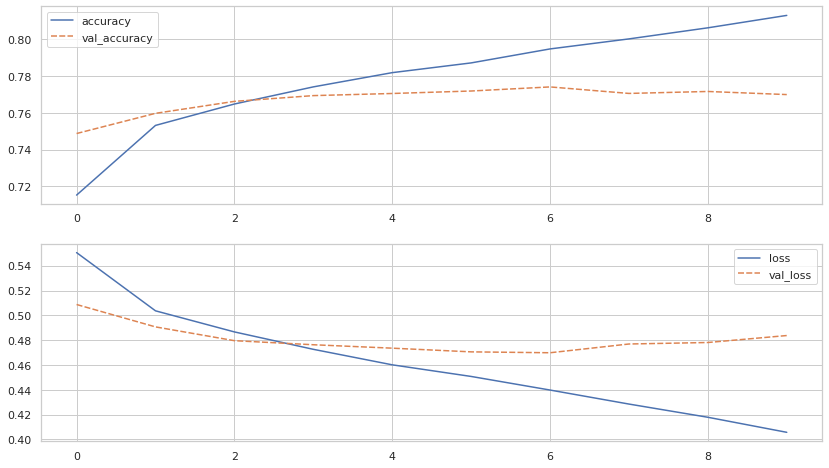

In [23]:
#@title Plot training metrics
rows, cols = 2, 1
fig, axes = plt.subplots(rows, cols, figsize=(7*rows, 8*cols))

accuracy = get_metrics(history.history, "accuracy")
loss = get_metrics(history.history, "loss")
sns.lineplot(data=accuracy, ax=axes[0])
sns.lineplot(data=loss, ax=axes[1])
plt.show()

In [24]:
# %load_ext tensorboard
# %tensorboard --logdir={tensorboard_logs_dir}

## Testing the model

In [25]:
reverse_word_index = dict(zip(word_index.values(), word_index.keys()))

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [26]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

# Expected output
# (1000, 16)

(117708, 100)


In [27]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

In [28]:
# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download('vecs.tsv')
#   files.download('meta.tsv')

## Saving the model to Google Drive

In [29]:
#@title Copy the model checkpoints and logs to Google Drive
from google.colab import drive

drive.mount('/content/drive')
google_drive_folder = "/content/drive/MyDrive/tensorflow"

!mkdir {google_drive_folder}
!cp -r {MODEL_LOGS_DIR} {google_drive_folder}

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/tensorflow’: File exists
